# Predicting Podcast Listening Times using PyTorch

## Competition Summary 📘
Welcome to the 2025 Kaggle Playground Series!

This series continues the tradition of offering fun, approachable competitions for the community to sharpen their machine learning skills. Each month, a new challenge arrives — and this time, your mission is to predict the listening time of a podcast episode.

The dataset (both train and test) was synthetically generated using a deep learning model trained on the Podcast Listening Time Prediction dataset. While the feature distributions are quite similar to the original, they’re not identical — feel free to explore the differences or even incorporate the original dataset into your workflow if it helps improve model performance.

📏 Evaluation Metric: Root Mean Squared Error (RMSE)

## My Approach 🧠 
My plan for this competition is fairly straightforward:

Exploratory Data Analysis (EDA) – to understand patterns, distributions, and spot any quirks in the data.

Modeling:

- Set up a data preprocessing pipeline.

- Train both a PyTorch neural network and an XGBoost model.

- Finally, ensemble the two models for improved predictions.

I'm using PyTorch mainly for learning purposes. That said, XGBoost is currently outperforming my NN, both in speed and accuracy. Still, I’m keen to keep experimenting and improving my neural network setup.

💡 If you have tips on optimizing PyTorch models for tabular data, or suggestions for handling embeddings better — I’d love to hear them!

## Current Issues & Help Wanted ⚠️ 
I'm running into a problem with the embedding layer in my neural network. When I generate new categorical features (e.g., via combinations of existing columns), some rare values show up in the validation/test set that weren’t seen during training. These unseen values are causing the embedding to crash.

I tried using the `OrdinalEncoder` with `handle_unknown='use_encoded_value'` and encoding unseen values as `-1`, then passing `padding_idx=1` to the embedding layer (as ChatGPT suggested) — but it’s still not working as expected.

Any help or ideas on how to safely handle unseen categorical values in embeddings would be greatly appreciated!


**Lets get started!!!!**

In [1]:
# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import warnings

# Disable warning
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
pd.set_option("display.max_columns", 500)

In [2]:
# Load training and test data
df_train = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")

print(f"Shape of df_train: {df_train.shape}, Shape of df_test: {df_test.shape}")

df_test.head()

Shape of df_train: (750000, 12), Shape of df_test: (250000, 11)


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,750000,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,750001,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,750002,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,750003,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,750004,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral


# Exploratory data analysis

## Missing values

When examining the dataset, only a few features contain substantial missing values:

- `Episode_Length_minutes`

- `Guest_Popularity_percentage`

Both of these have missing values in both the training and test sets, making them important to handle thoughtfully.

There’s also a minor issue with:

- `Number_of_Ads`
This feature only has one missing value in the training set, so it shouldn't be too difficult to deal with.

In [3]:
print("Missing values in the training data:")
print(df_train.isna().sum())
print("\nMissing values in the test data:")
print(df_test.isna().sum())

Missing values in the training data:
id                                  0
Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          87093
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    146030
Number_of_Ads                       1
Episode_Sentiment                   0
Listening_Time_minutes              0
dtype: int64

Missing values in the test data:
id                                 0
Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes         28736
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    48832
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64


## Episode length ⏱️

As expected, `Episode_Length_minutes` shows a strong positive correlation with the target variable, `Listening_Time_minutes`. That makes sense — longer episodes generally offer more listening time.

However, this feature comes with a few quirks:

There are some extreme outliers, most notably an episode in the test set listed as 78,486,264.0 minutes long (!).

Additionally, there are instances where `Listening_Time_minutes` exceeds the episode length, which shouldn't be possible under normal circumstances.

These inconsistencies are likely due to the synthetic nature of the dataset, as mentioned in various discussion posts on the forum.

In [4]:
print(f"The minimum episode length in the training data is {min(df_train['Episode_Length_minutes'].dropna())} minutes")
print(f"The maximum episode length in the training data is {max(df_train['Episode_Length_minutes'].dropna())} minutes")
print(f"The training data contains {(df_train['Episode_Length_minutes'] < 2).sum()} rows with episodes lengths < 2 minutes")
print(f"The training data contains {(df_train['Episode_Length_minutes'] > 120).sum()} rows with episodes lengths > 120 minutes")

print(f"\nThe minimum episode length in the test data is {min(df_test['Episode_Length_minutes'])} minutes")
print(f"The maximum episode length in the test data is {max(df_test['Episode_Length_minutes'])} minutes")
print(f"The test data contains {(df_test['Episode_Length_minutes'] < 2).sum()} rows with episodes lengths < 2 minutes")
print(f"The test data contains {(df_test['Episode_Length_minutes'] > 120).sum()} rows with episodes lengths > 120 minutes")

The minimum episode length in the training data is 0.0 minutes
The maximum episode length in the training data is 325.24 minutes
The training data contains 4 rows with episodes lengths < 2 minutes
The training data contains 9 rows with episodes lengths > 120 minutes

The minimum episode length in the test data is 2.47 minutes
The maximum episode length in the test data is 78486264.0 minutes
The test data contains 0 rows with episodes lengths < 2 minutes
The test data contains 4 rows with episodes lengths > 120 minutes


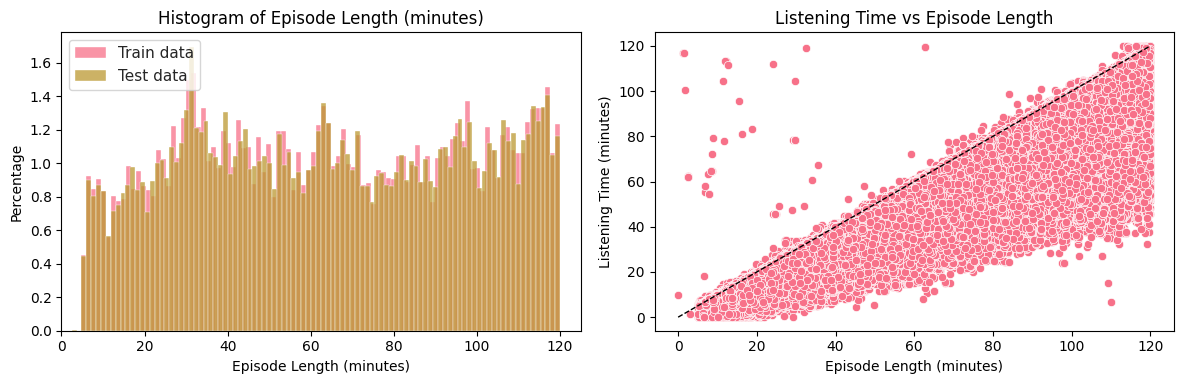

In [5]:
# Set up the figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Set the style and color palette
sns.set(style="white", palette="husl")

bins = 100

# Cap episode length values at 150 for easy plotting
df_train["Episode_Length_minutes"] = df_train["Episode_Length_minutes"].apply(lambda x: min(x, 120))
df_test["Episode_Length_minutes"] = df_test["Episode_Length_minutes"].apply(lambda x: min(x, 120))

# 1. Histogram of Episode Length 
sns.histplot(df_train["Episode_Length_minutes"], bins=bins, stat='percent', label='Train data', color=sns.color_palette("husl")[0], ax=axes[0])
sns.histplot(df_test["Episode_Length_minutes"], bins=bins, stat='percent', label='Test data', color=sns.color_palette("husl")[1], ax=axes[0])
axes[0].set_title("Histogram of Episode Length (minutes)")
axes[0].set_xlabel("Episode Length (minutes)")
axes[0].set_ylabel("Percentage")
axes[0].legend(loc='upper left')
axes[0].set_xlim(0, 125)

# 2. Scatter plot of Listening Time vs Episode Length 
sns.scatterplot(data=df_train, x="Episode_Length_minutes", y="Listening_Time_minutes", color=sns.color_palette("husl")[0], ax=axes[1])
axes[1].plot([0, 120],[0, 120],
             color="black", linestyle="--", linewidth=1)
axes[1].set_title("Listening Time vs Episode Length")
axes[1].set_xlabel("Episode Length (minutes)")
axes[1].set_ylabel("Listening Time (minutes)")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


## Podcast Name, Genre & Episode Title 🎙️

There’s something a bit unusual happening with the `Podcast_Name`, `Genre`, and `Episode_Title columns`:
- Combinations of `Podcast_Name` and `Episode_Title` appear multiple times across the dataset.
- What’s odd is that these same combinations are sometimes associated with different `Genres`.

🤔 This raises a few possibilities:
- Could this reflect multiple seasons or re-releases of the same episode under a different category?
- Or is this simply a quirk introduced by the synthetic generation of the dataset?
(Note: this pattern also appears in the original dataset, which is likely also synthetic!)

Interestingly:
- On their own, neither `Genre` nor `Podcast_Name` appear to be strong predictors of `Listening_Time_minutes`.
- But when combined, some distinct patterns emerge, suggesting there might be value in creating interaction features (e.g., `Podcast_Genre_Combo`).

In [6]:
# Count unique genres per podcast name
genre_check = df_train.groupby("Podcast_Name")["Genre"].nunique()

# Filter podcasts that have more than one unique genre
multi_genre_podcasts = genre_check[genre_check > 1]

if multi_genre_podcasts.empty:
    print("All Podcast_Name entries have a consistent Genre.")
else:
    print("Some Podcast_Name entries have multiple Genres assigned:")
    print(multi_genre_podcasts)

Some Podcast_Name entries have multiple Genres assigned:
Podcast_Name
Athlete's Arena        10
Brain Boost             9
Business Briefs         5
Business Insights       7
Comedy Corner           4
Crime Chronicles       10
Criminal Minds         10
Current Affairs         9
Daily Digest            9
Detective Diaries       8
Digital Digest          9
Educational Nuggets     9
Fashion Forward         9
Finance Focus          10
Fitness First          10
Funny Folks            10
Gadget Geek             9
Game Day               10
Global News             8
Health Hour             4
Healthy Living          9
Home & Living           9
Humor Hub              10
Innovators              9
Joke Junction          10
Laugh Line             10
Learning Lab            9
Life Lessons            9
Lifestyle Lounge        8
Market Masters          9
Melody Mix              9
Mind & Body             9
Money Matters          10
Music Matters           3
Mystery Matters        10
News Roundup        

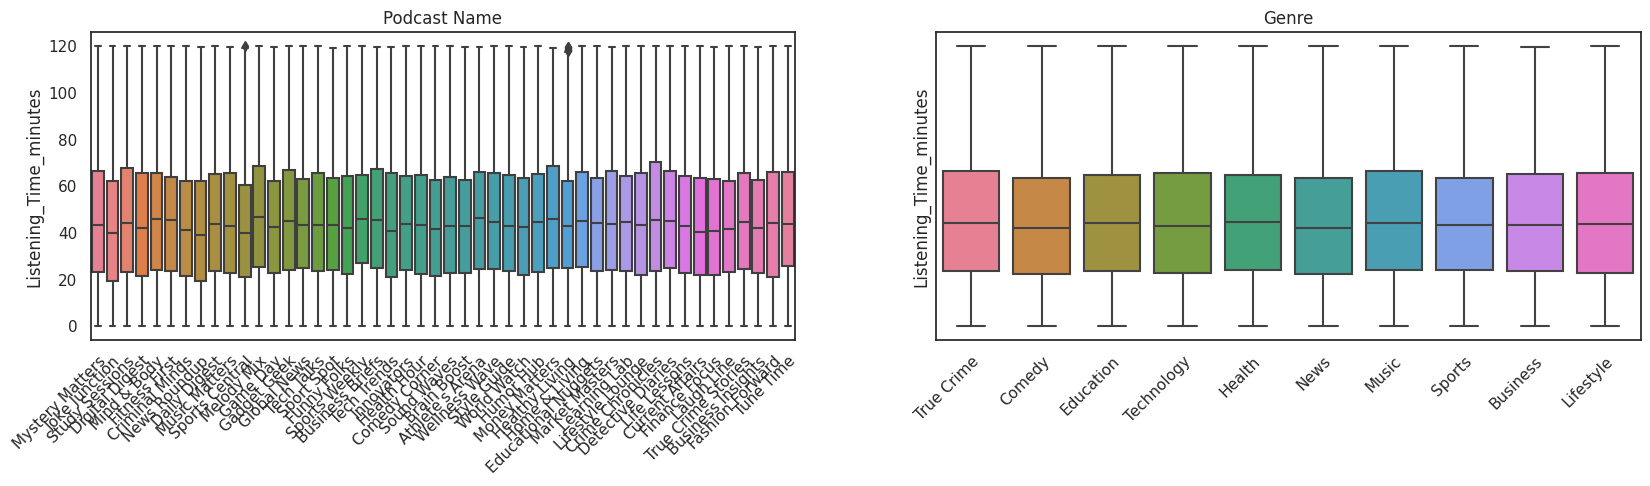

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharey=True)

# 1: Podcast name
ax = axes[0]
sns.boxplot(data=df_train, x="Podcast_Name", y="Listening_Time_minutes", ax=ax, palette="husl")
ax.set_title("Podcast Name")
ax.set_xlabel("")  # Optional: Clean up x-axis label
ax.tick_params(axis='x', rotation=45)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# 2: Podcast name
ax = axes[1]
sns.boxplot(data=df_train, x="Genre", y="Listening_Time_minutes", ax=ax,palette="husl")
ax.set_title("Genre")
ax.set_xlabel("")  # Optional: Clean up x-axis label
ax.tick_params(axis='x', rotation=45)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

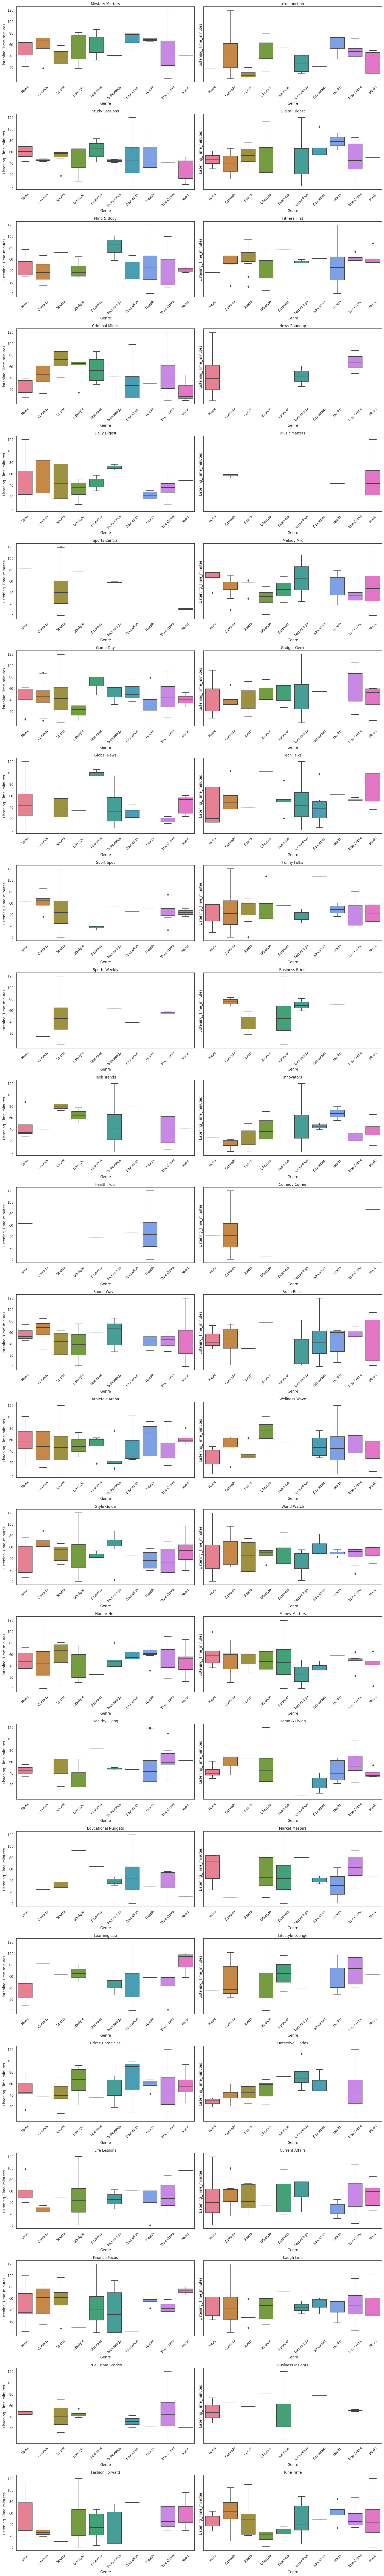

In [8]:
from math import ceil

# 1. Get unique podcast names and genres
podcast_names = df_train["Podcast_Name"].unique()
n_names = len(podcast_names)

# 2. Determine fixed genre order (sorted by mean listening time across all podcasts)
genre_order = df_train.groupby("Genre")["Listening_Time_minutes"].mean().sort_values().index.tolist()

# 3. Create subplot grid with 2 columns
n_rows = ceil(n_names / 2)
fig, axes = plt.subplots(n_rows, 2, figsize=(18, 5 * n_rows), sharey=True)

# Flatten axes array for easy indexing
axes = axes.flatten()

# 4. Plot each podcast
for i, name in enumerate(podcast_names):
    # Subset and ensure all genres are present by reindexing
    subset = df_train[df_train["Podcast_Name"] == name]
    
    # Reindex by full genre order to include missing genres as empty (NaNs)
    dummy = pd.DataFrame({"Genre": genre_order})
    merged = dummy.merge(subset, on="Genre", how="left")  # keeps all genres

    sns.boxplot(data=merged, x="Genre", y="Listening_Time_minutes", ax=axes[i], palette="husl", order=genre_order)
    axes[i].set_title(f"{name}", fontsize=12)
    axes[i].set_xticklabels(genre_order, rotation=45, ha='center')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Episode Number from Title 🔢

Looking more closely at the `Episode_Title`, it's possible to extract an episode number.

**Hypothesis**

Intuitively, one might expect some correlation between episode number and listening time:
- Listeners tuning in to, say, Episode 90 are likely fans and may listen through to the end. Meanwhile, Episode 1 might attract new listeners who quickly decide it’s not for them.
- However, this hypothesized trend does not clearly appear in the data.
  
**Adjusted Analysis**

Since `Listening_Time_minutes `is strongly correlated with `Episode_Length_minutes`, I tried normalizing the target by calculating the fraction of the episode that was listened.But even after this adjustment, there was no obvious correlation between episode number and engagement.

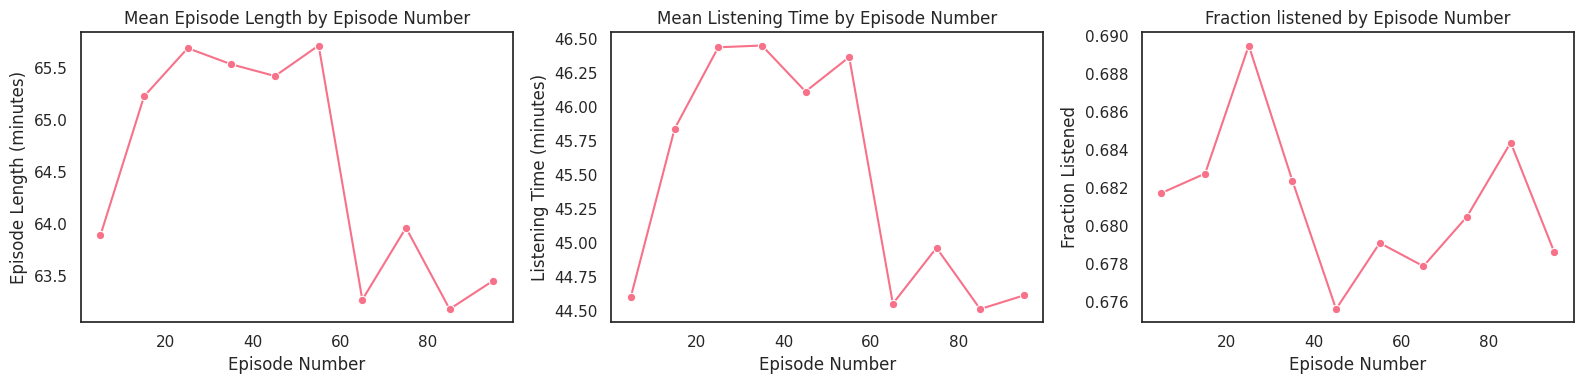

In [9]:
# Extract and convert episode number
df_train["Episode_Number"] = df_train["Episode_Title"].str.extract(r"Episode\s+(\d+)", expand=False).astype(int)
# Bin episode numbers into groups of 10
df_train["Episode_Bin"] = pd.cut(df_train["Episode_Number"], bins=range(0, df_train["Episode_Number"].max() + 10, 10), right=False)
# Add bin center
df_train["Bin_Center"] = df_train["Episode_Bin"].apply(lambda x: (x.left + x.right) / 2)

# Group by Episode_Number and calculate the mean values
df_train["Fraction_Listened"] = df_train["Listening_Time_minutes"] / df_train["Episode_Length_minutes"] 
df_train["Fraction_Listened"] = df_train["Fraction_Listened"].replace(np.inf, np.nan)
episode_stats = df_train.groupby("Bin_Center")[["Episode_Length_minutes", "Listening_Time_minutes", "Fraction_Listened"]].mean().reset_index()

# Plot
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)

# Line plot for Episode Length
sns.lineplot(data=episode_stats, x="Bin_Center", y="Episode_Length_minutes", marker="o", ax=axes[0], color=sns.color_palette("husl", 1)[0])
axes[0].set_title("Mean Episode Length by Episode Number")
axes[0].set_ylabel("Episode Length (minutes)")
axes[0].set_xlabel("Episode Number")

# Line plot for Listening Time
sns.lineplot(data=episode_stats, x="Bin_Center", y="Listening_Time_minutes", marker="o", ax=axes[1], color=sns.color_palette("husl", 1)[0])
axes[1].set_title("Mean Listening Time by Episode Number")
axes[1].set_ylabel("Listening Time (minutes)")
axes[1].set_xlabel("Episode Number")

# Line plot for Listening Time
sns.lineplot(data=episode_stats, x="Bin_Center", y="Fraction_Listened", marker="o", ax=axes[2], color=sns.color_palette("husl", 1)[0])
axes[2].set_title("Fraction listened by Episode Number")
axes[2].set_ylabel("Fraction Listened")
axes[2].set_xlabel("Episode Number")

plt.tight_layout()
plt.show()


## Other categorical features 🏷️

Let’s explore some of the categorical variables in the dataset: `Publication_Day`, `Publication_Time`, `Genre`, `Episode_Sentiment`

**Observations**

There are some correlations between these features and the target listening_time_minutes, but the average effects appear to be quite small. For example:
- With `Episode_Sentiment`, the mean listening time increases only slightly: from ~44 minutes to ~46 minutes going from a negative to a positive sentiment

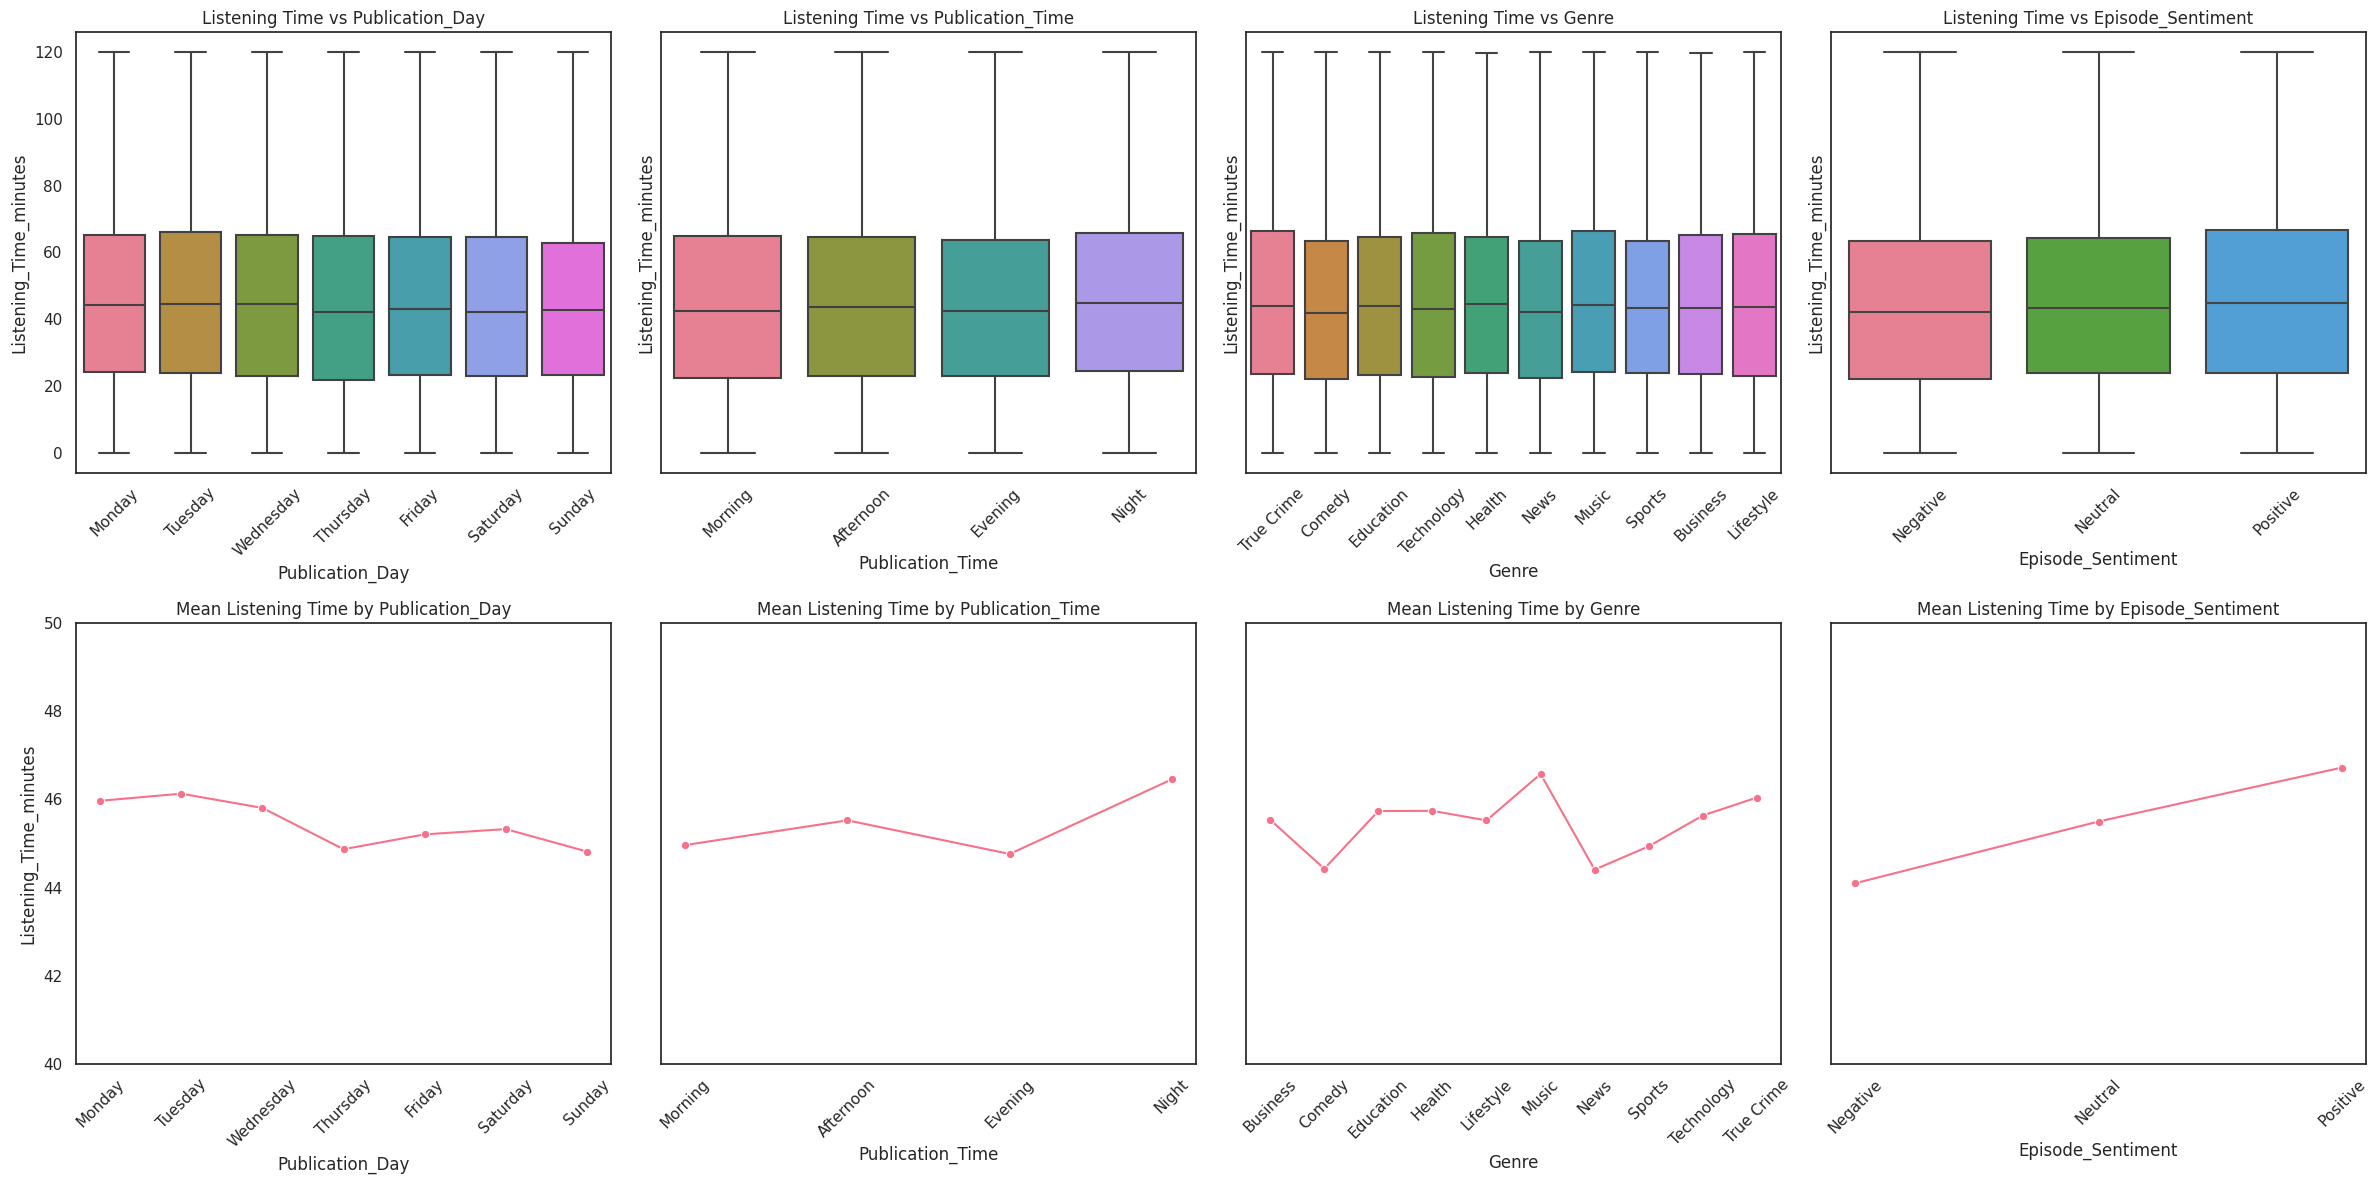

In [10]:
# List  categorical features to plot
categorical_features = ["Publication_Day", "Publication_Time", "Genre", "Episode_Sentiment"]

# Order oridnal features
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_train["Publication_Day"] = pd.Categorical(df_train["Publication_Day"], categories=day_order, ordered=True)
time_order = ["Morning", "Afternoon", "Evening", "Night"]
df_train["Publication_Time"] = pd.Categorical(df_train["Publication_Time"], categories=time_order, ordered=True)
sentiment_order = ["Negative", "Neutral", "Positive"]
df_train["Episode_Sentiment"] = pd.Categorical(df_train["Episode_Sentiment"], categories=sentiment_order, ordered=True)

# Plot setup
num_features = len(categorical_features)
fig, axes = plt.subplots(2, num_features, figsize=(6 * num_features, 12), sharey='row')

# Plot each boxplot in a subplot
for i, feature in enumerate(categorical_features):
    sns.boxplot(data=df_train, x=feature, y="Listening_Time_minutes", ax=axes[0, i], palette="husl")
    axes[0, i].set_title(f"Listening Time vs {feature}")
    axes[0, i].tick_params(axis='x', rotation=45)

    means = df_train.groupby(feature)["Listening_Time_minutes"].mean().reset_index()    
    sns.lineplot(data=means, x=feature, y="Listening_Time_minutes", marker="o", ax=axes[1, i], color=sns.color_palette("husl", 1)[0])
    axes[1, i].set_title(f"Mean Listening Time by {feature}")
    axes[1, i].tick_params(axis='x', rotation=45)
    axes[1, i].set_ylim(40, 50)

plt.tight_layout()
plt.show()


## Publication time & day 🕒

Let’s take a closer look at `Publication_Day` and `Publication_Time`.

At first glance, these features show little standalone correlation with `Listening_Time_minutes`. However, that might be because — like with `Podcast_Name` and `Genre` — their impact is more nuanced and dependent on interactions.

For example:
- One might expect that podcasts released late at night or during work hours could perform differently on weekends vs weekdays.
- Perhaps content published on Friday evenings or Sunday mornings has a different engagement profile compared to midweek or early morning drops.

However, after examining combinations of `Publication_Day` × `Publication_Time`, no clear trend emerges from the data. Listening behavior doesn’t appear to shift significantly depending on these timing combinations.

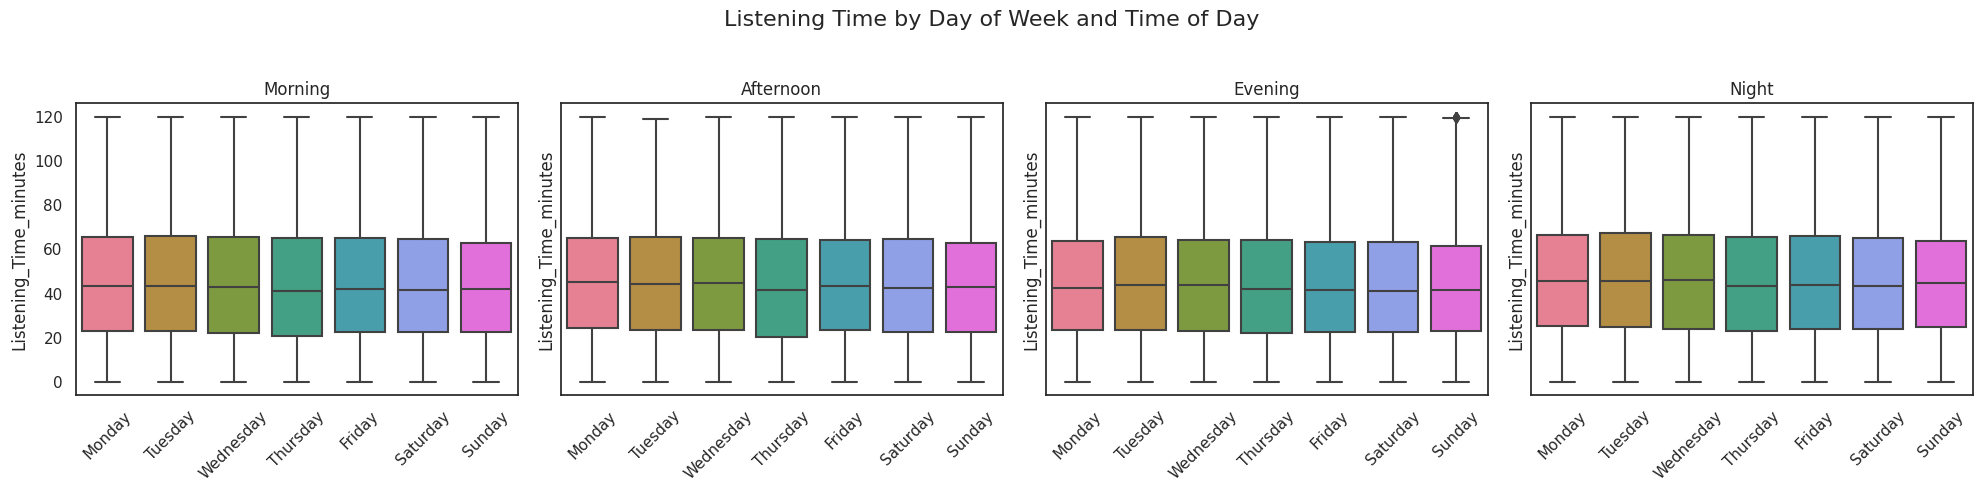

In [11]:

# Set the day order and time of day order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
time_order = ["Morning", "Afternoon", "Evening", "Night"]

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for i, time in enumerate(time_order):
    ax = axes[i]
    subset = df_train[df_train["Publication_Time"] == time]

    sns.boxplot(
        data=subset,
        x="Publication_Day",
        y="Listening_Time_minutes",
        order=day_order,
        ax=ax,
        palette="husl"
    )

    ax.set_title(f"{time}")
    ax.set_xlabel("")  # Optional: Clean up x-axis label
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), ha='center')  # Center tick labels

fig.suptitle("Listening Time by Day of Week and Time of Day", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Nobody likes Ads 📉

Let’s be honest — nobody tunes into a podcast hoping for more ads. So it’s no surprise that the `Number_of_Ads` feature shows a negative correlation with `Listening_Time_minutes`.

**Observations**
- As the number of ads increases, average listening time drops.
- There are a few weird entries and strong outliers, which again seem to reflect the synthetic nature of the dataset (e.g., episodes with an unrealistic number of ads or very short durations with high ad counts).
- When plotting the Ad denisty (ads/minute), the negative trend becomes even clearer — higher ad density strongly correlates with lower engagement.

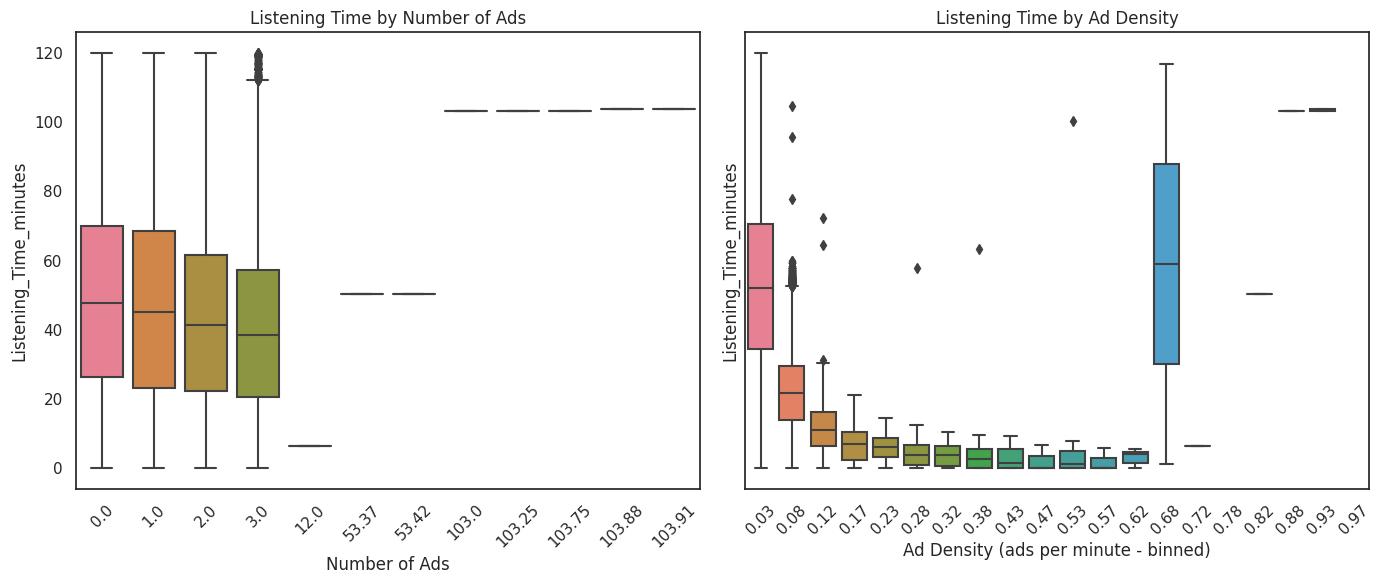

In [12]:
# Create Ad Density, handling NaNs
df_plot = df_train.copy()
df_plot["Ad_Density"] = df_plot["Number_of_Ads"] / df_plot["Episode_Length_minutes"]

# Binning 'Ad_Density' into categories 
bins = [i/20 for i in range(21)]  
bin_centers = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
labels = [f"{center:.2f}" for center in bin_centers]
df_plot["Ad_Density_Category"] = pd.cut(df_plot["Ad_Density"], bins=bins, labels=labels, right=False)

# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# 1. Boxplot: Listening Time vs Number of Ads
sns.boxplot(
    data=df_plot,
    x="Number_of_Ads",
    y="Listening_Time_minutes",
    ax=axes[0],
    palette="husl"
)
axes[0].set_title("Listening Time by Number of Ads")
axes[0].set_xlabel("Number of Ads")
axes[0].tick_params(axis='x', rotation=45)

# 2. Boxplot: Listening Time vs Ad Density
sns.boxplot(
    data=df_plot.dropna(subset=["Ad_Density_Category"]),
    x="Ad_Density_Category",
    y="Listening_Time_minutes",
    ax=axes[1],
    palette="husl"
)
axes[1].set_title("Listening Time by Ad Density")
axes[1].set_xlabel("Ad Density (ads per minute - binned)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Host & Guest popularity 🌟 

Lastly, let’s explore `Host_Popularity_percentage` and `Guest_Popularity_percentage`.

**Initial Insight:**
- On their own, neither feature shows a strong correlation with `Listening_Time_minutes`.
- This suggests that celebrity status alone isn’t a strong predictor of engagement — at least not in a linear way.

**Interestingly:**
- Podcasts where the host is significantly more popular than the guest tend to have slightly longer listening times.
- This might suggest that audiences are more loyal to the host’s brand, sticking around even when the guest is less well-known.


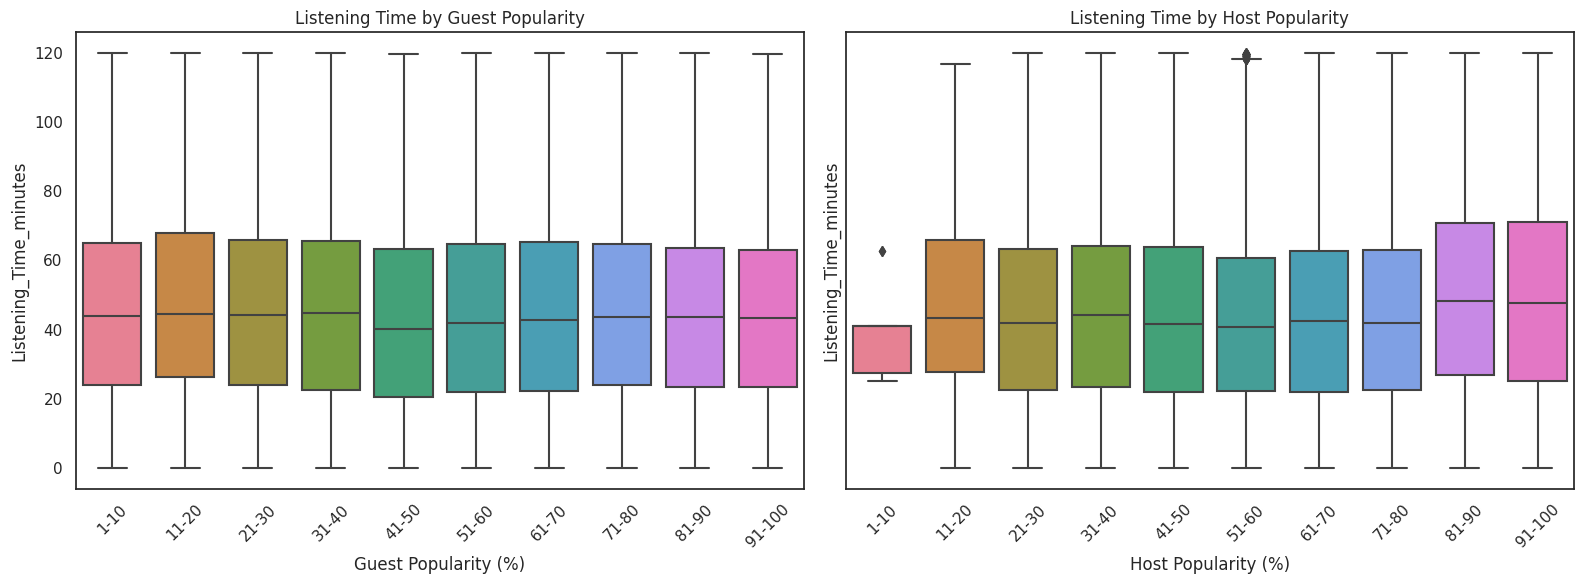

In [13]:
df_plot = df_train.copy()

df_plot["Guest_Popularity_percentage"] = df_plot["Guest_Popularity_percentage"].clip(lower=1, upper=100)
df_plot["Host_Popularity_percentage"] = df_plot["Host_Popularity_percentage"].clip(lower=1, upper=100)

pop_bins = list(range(1, 101, 10)) + [101]  # [1, 11, 21, ..., 91, 101]
bin_labels = [f"{i}-{i+9}" for i in range(1, 100, 10)]  # '1-10', '11-20', ..., '91-100'

df_plot["Guest_Popularity_Binned"] = pd.cut(df_plot["Guest_Popularity_percentage"], bins=pop_bins, labels=bin_labels, right=False)
df_plot["Host_Popularity_Binned"] = pd.cut(df_plot["Host_Popularity_percentage"], bins=pop_bins, labels=bin_labels, right=False)


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Guest Popularity
sns.boxplot(data=df_plot,
            x="Guest_Popularity_Binned",
            y="Listening_Time_minutes",
            palette="husl",
            ax=axes[0])
axes[0].set_title("Listening Time by Guest Popularity")
axes[0].set_xlabel("Guest Popularity (%)")
axes[0].tick_params(axis='x', rotation=45)
#axes[0].set_ylim(0, 1)


# Host Popularity
sns.boxplot(data=df_plot,
            x="Host_Popularity_Binned",
            y="Listening_Time_minutes",
            palette="husl",
            ax=axes[1])
axes[1].set_title("Listening Time by Host Popularity")
axes[1].set_xlabel("Host Popularity (%)")
axes[1].tick_params(axis='x', rotation=45)
#axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


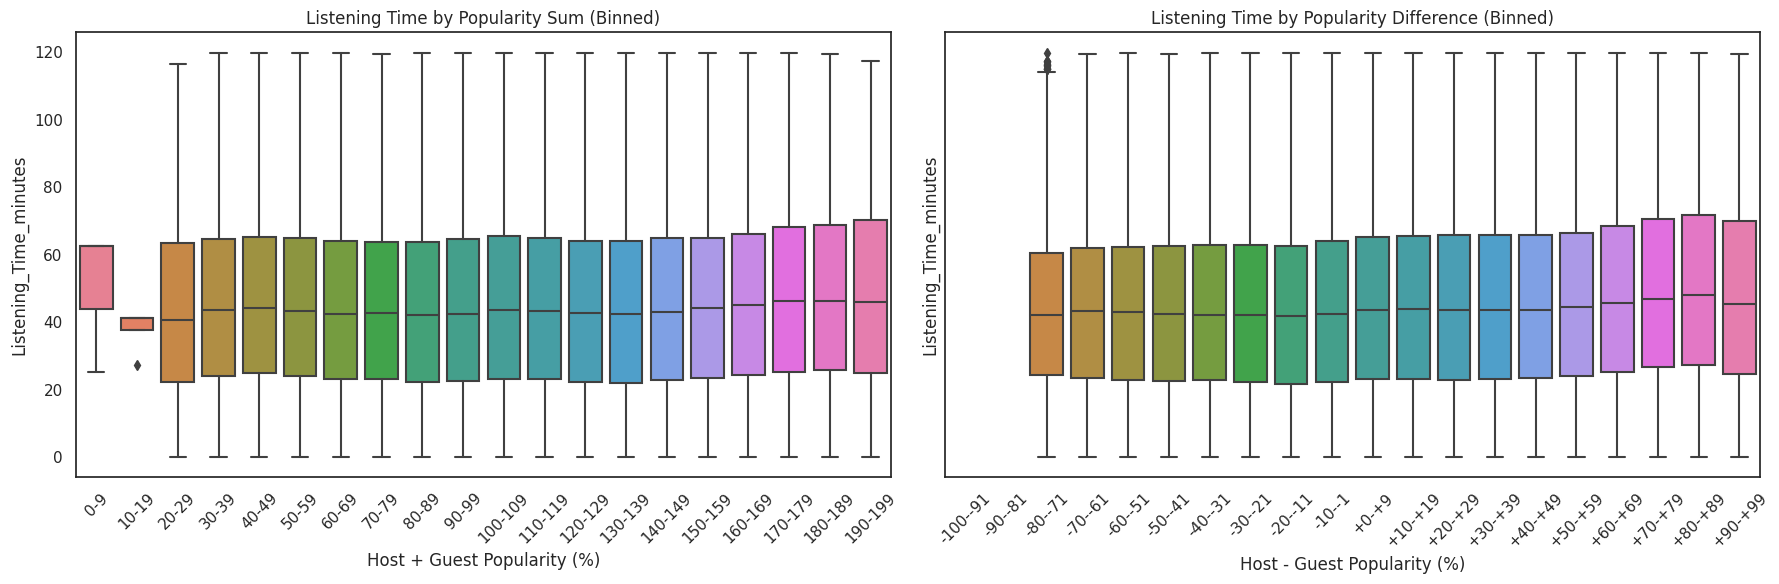

In [14]:
# Calculate sum and difference
df_plot["Popularity_Sum"] = df_plot["Guest_Popularity_percentage"] + df_plot["Host_Popularity_percentage"]
df_plot["Popularity_Diff"] = df_plot["Host_Popularity_percentage"] - df_plot["Guest_Popularity_percentage"]

# Sum: range will be 2 to 200
sum_bins = list(range(0, 201, 10))
sum_labels = [f"{i}-{i+9}" for i in range(0, 200, 10)]
df_plot["Popularity_Sum_Binned"] = pd.cut(df_plot["Popularity_Sum"], bins=sum_bins, labels=sum_labels, right=False)

# Diff: range -99 to +99, center at 0
diff_bins = list(range(-100, 110, 10))  # allows for -100 to 100
diff_labels = [f"{i:+}-{i+9:+}" for i in range(-100, 100, 10)]
df_plot["Popularity_Diff_Binned"] = pd.cut(df_plot["Popularity_Diff"], bins=diff_bins, labels=diff_labels, right=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Popularity Sum
sns.boxplot(data=df_plot,
            x="Popularity_Sum_Binned",
            y="Listening_Time_minutes",
            palette="husl",
            ax=axes[0])
axes[0].set_title("Listening Time by Popularity Sum (Binned)")
axes[0].set_xlabel("Host + Guest Popularity (%)")
axes[0].tick_params(axis='x', rotation=45)

# Popularity Difference
sns.boxplot(data=df_plot,
            x="Popularity_Diff_Binned",
            y="Listening_Time_minutes",
            palette="husl",
            ax=axes[1])
axes[1].set_title("Listening Time by Popularity Difference (Binned)")
axes[1].set_xlabel("Host - Guest Popularity (%)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Data Preprocessing Pipeline 🛠️

In this section, I define the data preprocessing pipeline using the scikit-learn library. The pipeline is designed to prepare the data for both the XGBoost and PyTorch neural network models, with some steps being model-specific.

🔄 Key Steps
1. Outlier Removal: Filter out extreme and clearly unrealistic values
2. Missing Value Imputation: Imputation is optional and only applied where necessary. XGBoost handles missing values internally, so imputation is mostly relevant for the neural network.
3. Feature Engineering: New features are created based on earlier EDA (e.g., ads_per_minute, popularity_gap, Podcast_Genre_Combo, etc.).
4. Scaling & Encoding: Required for the neural network, which expects numerical inputs and benefits from standardized features. Numerical features are scaled (e.g., StandardScaler). Categorical features are encoded (e.g., OrdinalEncoder or embedding-friendly mappings). XGBoost does not require scaling or encoding — it works directly with raw data and categorical columns (if supported).

🧩 Output Format
- For XGBoost, the processor returns a single DataFrame with all features combined.
- For the neural network, the processor returns two separate DataFrames:
    - One for categorical features (for embeddings)
    - One for numerical features (for direct input after scaling)

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

In [16]:
class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, remove_outliers=True):
        self.remove_outliers = remove_outliers

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        if self.remove_outliers:
            X_copy["Guest_Popularity_percentage"] = X_copy["Guest_Popularity_percentage"].clip(lower=1, upper=100)
            X_copy["Host_Popularity_percentage"] = X_copy["Host_Popularity_percentage"].clip(lower=1, upper=100)
            X_copy["Episode_Length_minutes"] = X_copy["Episode_Length_minutes"].clip(lower=2, upper=120)
            X_copy["Number_of_Ads"] = X_copy["Number_of_Ads"].clip(lower=0, upper=3)
            
        return X_copy

In [17]:
class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self, impute_missing=True, impute_simple=True):
        self.impute_missing = impute_missing # True or False
        self.impute_simple = impute_simple 
        # Store median values for imputing
        self.num_medians = None # medians of all numerical columns
        self.group_medians_episode = None # medians Epiosode_length_minutes grouped by Genre and Podcast_Title
        self.group_medians_guest = None # medians Guest_Popularity_percentage grouped by Genre 
        # Store numerical and categorical collumn names
        self.num_cols = None  
        self.cat_cols = None 
    
    def fit(self, X, y=None):

        X_copy = X.copy()
        
        # Identify numerical and categorical columns
        self.num_cols = X_copy.select_dtypes(include=["number"]).columns.tolist()
        self.cat_cols = X_copy.select_dtypes(include=["object", "category"]).columns.tolist()

        # Compute and store median of numerical columns for imputation
        self.num_medians = X_copy[self.num_cols].median()

        if not self.impute_simple:
            # Groupwise medians
            self.group_medians_episode = (
                X_copy.groupby(['Podcast_Name', 'Genre'])['Episode_Length_minutes']
                .median()
                .reset_index()
                .rename(columns={'Episode_Length_minutes': 'Median_Episode_Length'})
            )
    
            self.group_medians_guest = (
                X_copy.groupby('Genre')['Guest_Popularity_percentage']
                .median()
                .reset_index()
                .rename(columns={'Guest_Popularity_percentage': 'Median_Guest_Popularity'})
            )

        return self

    def transform(self, X):
        X_copy = X.copy()

        # Impute Episode_Length_minutes and Guest_Popularity_percentage
        if self.impute_missing and not self.impute_simple:
            
            # Merge group medians for episode lenght
            X_copy = X_copy.merge(self.group_medians_episode,how='left',on=['Podcast_Name', 'Genre'])
            X_copy['Episode_Length_minutes'] = X_copy['Episode_Length_minutes'].fillna(X_copy['Median_Episode_Length'])
            X_copy = X_copy.drop(columns='Median_Episode_Length')

            # Merge group medians for guest popularity
            X_copy = X_copy.merge(self.group_medians_guest, how='left',on='Genre')
            X_copy['Guest_Popularity_percentage'] = X_copy['Guest_Popularity_percentage'].fillna(X_copy['Median_Guest_Popularity'])
            X_copy = X_copy.drop(columns='Median_Guest_Popularity')
            
        # Impute other missing values
        if self.impute_missing:
            X_copy[self.num_cols] = X_copy[self.num_cols].fillna(self.num_medians)
            X_copy[self.cat_cols] = X_copy[self.cat_cols].fillna("Missing")
        
        return X_copy

In [18]:
from itertools import combinations

class AttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_cat_combi=True, add_others=True):
        self.add_cat_combi = add_cat_combi # Add all combinations of categorical features
        self.add_others = add_others # add other engineered features
        self.cat_cols = None
        
    def fit(self, X, y=None):
        # Identify categorical cols
        self.cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
        return self


    def transform(self, X):
        X_copy = X.copy()

        if self.add_cat_combi:
            for col1, col2 in combinations(self.cat_cols, 2):
                new_col_name = f"{col1}_{col2}"
                X_copy[new_col_name] = X_copy[col1].astype(str) + "_" + X_copy[col2].astype(str)

        if self.add_others:
            X_copy["Ad_Density"] = X_copy["Number_of_Ads"] / X_copy["Episode_Length_minutes"]
            X_copy["Episode_Number"] = X_copy["Episode_Title"].str.extract(r"Episode\s+(\d+)", expand=False).astype(int)
            X_copy["Popularity_Diff"] = X_copy["Host_Popularity_percentage"] - X_copy["Guest_Popularity_percentage"]
            if not self.add_cat_combi:
                #X_copy["Podcast_Name_Genre"] = X_copy["Podcast_Name"].astype(str) + "_" + X_copy["Genre"].astype(str)
                pass
                
        return X_copy

In [19]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

class GeneralPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, scaler=StandardScaler(), impute_missing=True, label_encode=True, split_cat_num=True):
        self.scaler = scaler
        self.impute_missing = impute_missing
        self.label_encode = label_encode
        self.split_cat_num = split_cat_num

        self.num_cols = None
        self.cat_cols = None
        self.num_means = None
        self.cat_encoder = None

    def fit(self, X, y=None):
        X_copy = X.copy()

        # Identify column types
        self.num_cols = X_copy.select_dtypes(include=["number"]).columns.tolist()
        self.cat_cols = X_copy.select_dtypes(include=["object", "category"]).columns.tolist()

        # Compute numerical imputation values
        self.num_means = X_copy[self.num_cols].median()

        # Fit scaler
        if self.scaler:
            self.scaler.fit(X_copy[self.num_cols].fillna(self.num_means))

        # Fit ordinal encoder with safe handling of unknowns
        if self.label_encode:
            self.cat_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan) 
            self.cat_encoder.fit(X_copy[self.cat_cols].fillna("Missing"))

        return self

    def transform(self, X):
        X_copy = X.copy()

        # Impute missing numerical values
        if self.impute_missing:
            X_copy[self.num_cols] = X_copy[self.num_cols].fillna(self.num_means)
            X_copy[self.cat_cols] = X_copy[self.cat_cols].fillna("Missing")

        # Scale numerical features
        if self.scaler:
            X_copy[self.num_cols] = self.scaler.transform(X_copy[self.num_cols])

        # Encode categorical features
        if self.label_encode:
            X_copy[self.cat_cols] = self.cat_encoder.transform(X_copy[self.cat_cols])
        else:
            X_copy[self.cat_cols] = X_copy[self.cat_cols].astype("category")

        # Return numerical and categorical columns separately or combined
        if self.split_cat_num:
            return X_copy[self.num_cols], X_copy[self.cat_cols]
        else:
            return X_copy


In [20]:
class FeatureSelector(BaseEstimator, TransformerMixin):   
    def __init__(self, remove_features=True, features_to_remove=None, features_to_keep=None):
        self.remove_features = remove_features # Remove features_to_remove, if False keep features_to_keep
        self.features_to_remove = features_to_remove
        self.features_to_keep = features_to_keep
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X_copy = X.copy()

        if self.remove_features:
            cols = list(X_copy.columns) 
            cols_to_keep =  [col for col in cols if col not in self.features_to_remove]
            return X_copy[cols_to_keep]
        else:
            return X_copy[ self.features_to_keep]

In [21]:
from sklearn.pipeline import Pipeline

# Define the features to remove
cols_to_remove = ["id", "Listening_Time_minutes"]

# Preprocessing for XGBoost model
feature_engineering_pipeline_xgb = Pipeline(steps=[
    ("Cleaning", DataCleaner(remove_outliers=True)),
    ("Imputation", CustomImputer(impute_missing=False, impute_simple=False)),
    ("Feature_engineering", AttributeAdder(add_cat_combi=False, add_others=False)),
])

preprocessor_xgboost = Pipeline(steps=[ # Chain feature engineering, selection and preprocessing
    ("feature_engineering", feature_engineering_pipeline_xgb),
    ("feature_selection", FeatureSelector(remove_features=True, features_to_remove=cols_to_remove)),
    ("preprocessing", GeneralPreprocessor(scaler=None, impute_missing=False, label_encode=False, split_cat_num=False))
])


# Preprocessing for NN model
feature_engineering_pipeline_NN = Pipeline(steps=[
    ("Cleaning", DataCleaner(remove_outliers=True)),
    ("Imputation", CustomImputer(impute_missing=True, impute_simple=True)),
    ("Feature_engineering", AttributeAdder(add_cat_combi=False, add_others=True)),
])

preprocessor_NN = Pipeline(steps=[ # fill missing values for engineered features??
    ("feature_engineering", feature_engineering_pipeline_NN),
    ("feature_selection", FeatureSelector(remove_features=True, features_to_remove=cols_to_remove)),
    ("preprocessing", GeneralPreprocessor(scaler=StandardScaler(), impute_missing=True, label_encode=True, split_cat_num=True))
])

In [22]:
# Check preprocessing pipeline
df_train = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")

X_train_num, X_train_cat = preprocessor_NN.fit_transform(df_train)
X_train_num.head()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Ad_Density,Episode_Number,Popularity_Diff
0,-0.018947,0.653654,0.042273,-1.213263,-0.646657,1.657582,0.408844
1,1.786473,0.310006,0.918477,0.586959,-0.322320,-0.906009,-0.482160
2,0.305616,0.442044,-1.705044,-1.213263,-0.646657,-1.262063,1.581031
3,0.088488,-0.115401,1.026191,0.586959,-0.068190,-0.229506,-0.849997
4,1.486753,0.883628,0.242034,1.487069,-0.119253,1.230317,0.413560


# The Loss Function

In [23]:
# Define loss function
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps # Prevent issues when mse=0
        
    def forward(self, y_h, y):
        loss =  torch.sqrt(self.mse(y_h, y) + self.eps)
        return loss

loss_func = RMSELoss()

# Training and predictions with XGBoost 🚂

In this section, I’ll walk through the process of training, fitting, and making predictions with an XGBoost model.

🔄 **Cross-Validation Setup**
- To ensure robust model performance, I’m using K-Fold cross-validation. This helps prevent overfitting and gives a more reliable estimate of the model's generalization ability.
- Preprocessing steps (like scaling, encoding, and imputation) are performed within the cross-validation loop to prevent data leakage between training and validation sets.

⚙️ **Model Setup and Training**
- To fine-tune training, I’ll use a learning rate scheduler that progressively reduces the learning rate during training. This often helps the model converge more efficiently and avoid overshooting optimal solutions.

🔮 **Making Predictions**
- After training, predictions are made on the test set (and out-of-fold validation set). These are then used to calculate the final evaluation metric (RMSE).

In [24]:
# Learning rate scheduler
import xgboost as xgb

class CustomLRScheduler(xgb.callback.TrainingCallback):
    def __init__(self, factor=0.5, patience=20, min_lr=1e-5, start_lr=0.01):
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.start_lr = start_lr
        self.wait = 0
        self.best_score = float("inf")
        self.current_lr = start_lr

    def before_training(self, model):
        model.set_param("learning_rate", self.current_lr)
        return model

    def after_iteration(self, model, epoch, evals_log):
        score = evals_log["validation_0"]["rmse"][-1]
        if score < self.best_score:
            self.best_score = score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                new_lr = max(self.current_lr * self.factor, self.min_lr)
                if new_lr < self.current_lr:
                    print(f"Reducing learning rate to {new_lr:.6f}")
                    self.current_lr = new_lr
                    model.set_param("learning_rate", self.current_lr)
                self.wait = 0
        return False

In [25]:
 # Training function for xgboost model
def fit_predict_xgboost_KFold(model, kf, train_df, test_df):
    oof = np.zeros(len(train_df))
    pred = np.zeros(len(test_df))

    # Main loop
    for i, (train_index, val_index) in enumerate(kf.split(train_df)):
    
        print("#"*100)
        print(f"### Fold {i+1}")
        print("#"*100)

         # Split features and targets training set
        X = train_df.drop(columns=["Listening_Time_minutes"]).copy()
        y = train_df["Listening_Time_minutes"].copy()
        
        # Prepare training data
        X_train = X.loc[train_index, :]
        X_train_transformed = preprocessor_xgboost.fit_transform(X_train)
        y_train = y.loc[train_index].copy()
            
        # Prepare validation data
        X_val = X.loc[val_index, :]
        X_val_transformed = preprocessor_xgboost.transform(X_val)
        y_val = y.loc[val_index].copy()

        # Prepare test data
        X_test_transformed = preprocessor_xgboost.transform(test_df)

        # Set callbacks
        model.set_params(callbacks=[
            EarlyStopping(rounds=100, save_best=True),
            CustomLRScheduler(factor=0.5, patience=20, min_lr=1e-5, start_lr=0.1)])
       
        # Fit model
        model.fit(
            X_train_transformed, y_train,
            eval_set=[(X_val_transformed, y_val)],
            verbose=200)
        
        # Inner oof (out-of-fold predictions)
        oof[val_index] += model.predict(X_val_transformed)
        # Inner test (test predictions)
        pred += model.predict(X_test_transformed)

    # Calculate average predictions
    pred /= kf.get_n_splits() 

    return oof, pred

In [26]:
from sklearn.model_selection import KFold
from xgboost.callback import EarlyStopping
import xgboost as xgb

FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Data
df_train = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")

# Model
params = {'max_depth': 14, 
          'learning_rate': 0.1, 
          'n_estimators': 2000, 
          'subsample': 0.8, 
          'colsample_bytree': 0.8,
          'min_child_weight': 40, 
          'enable_categorical': True,
          'tree_method': 'hist',
          'objective':'reg:squarederror',
          'eval_metric':'rmse'}

model_xgb = xgb.XGBRegressor(**params)


oof_xgb, pred_xgb = fit_predict_xgboost_KFold(model_xgb, kf, df_train, df_test)   

####################################################################################################
### Fold 1
####################################################################################################
[0]	validation_0-rmse:25.07732
Reducing learning rate to 0.050000
Reducing learning rate to 0.025000
Reducing learning rate to 0.012500
Reducing learning rate to 0.006250
Reducing learning rate to 0.003125
[194]	validation_0-rmse:12.85124
####################################################################################################
### Fold 2
####################################################################################################
[0]	validation_0-rmse:25.10913
Reducing learning rate to 0.050000
Reducing learning rate to 0.025000
[200]	validation_0-rmse:12.88416
Reducing learning rate to 0.012500
Reducing learning rate to 0.006250
[400]	validation_0-rmse:12.87789
[600]	validation_0-rmse:12.87594
Reducing learning rate to 0.003125
Reducing learning rate to 0.00

# Training and predictions with PyTorch Neural Network 🤖

In this section, I will walk through the process of training, fitting, and predicting with a PyTorch neural network (NN), taking a similar approach to the XGBoost model, with K-Fold cross-validation and a learning rate scheduler.

⚙️ **Model Setup and Training**
- PyTorch NN Architecture: The setup of the training loop (excluding the cross-validation) is inspired by the 'PyTorch Computer Vision Cookbook', which provides a flexible and scalable approach for training deep learning models.
- Model Architecture: The neural network architecture is based on the work of MuQingyu666 (https://www.kaggle.com/code/muqingyu666/feature-engineering-tabularnn-approach)

In [27]:
# Custom Dataset
class PodcastDataset(Dataset):
    def __init__(self, X_cats, X_nums, y=None): # pass in DataFrames
        self.X_cats = torch.tensor(X_cats.values, dtype=torch.long)  # For embeddings
        self.X_nums = torch.tensor(X_nums.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1) if y is not None else None # None for test set
    
    def __len__(self):
        return len(self.X_cats)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X_cats[idx], self.X_nums[idx], self.y[idx]
        else: 
            return self.X_cats[idx], self.X_nums[idx]

In [28]:
# Custom NN model
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, embedding_sizes, num_numeric, hidden_sizes=[128, 64, 32]):
        super(Net, self).__init__()

        # Embedding layers: list of (num_categories, embedding_dim)
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_categories, emb_dim) for num_categories, emb_dim in embedding_sizes
        ])

        self.emb_output_dim = sum([emb_dim for _, emb_dim in embedding_sizes]) # Add 1 for unknown values, , padding_idx=-1

        # NN layers after embedding
        self.layers = nn.Sequential(
            nn.Linear(self.emb_output_dim + num_numeric, hidden_sizes[0]),
            nn.BatchNorm1d(hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.BatchNorm1d(hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.BatchNorm1d(hidden_sizes[2]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[2], 1),
        )

    def forward(self, x_cat, x_num):
        # Apply embedding
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        # Concatenate numerical and embeddind features
        x = torch.cat(embedded + [x_num], dim=1)
        # Psss trough layers
        x = self.layers(x)
        return x  

In [29]:
import copy
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']
        

def loss_batch(loss_func, yb, yb_h, device, opt=None):
    # Obtain loss
    yb, yb_h = yb.to(device), yb_h.to(device)
    loss = loss_func(yb_h, yb)
    
    if opt:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item()


def loss_epoch(model, loss_func, dataset_loader, device, opt=None):
    loss = 0.
    len_data = len(dataset_loader) # number of batches
    
    for xb_cat, xb_num, yb in dataset_loader: # loop over batches
        xb_cat, xb_num, yb = xb_cat.to(device), xb_num.to(device), yb.to(device)
        yb_h = model(xb_cat, xb_num) # forward pass
        loss_b = loss_batch(loss_func, yb, yb_h, device, opt)
        loss += loss_b
        
    loss /= len_data
    return loss


def train_val(model, params):
    # Unpack parameters
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    lr_scheduler = params["lr_scheduler"]
    device = params["device"]

    # History of loss values
    loss_history={"train": [],"val": []}
    # Deep copy of best model
    best_model_wts = copy.deepcopy(model.state_dict())
    # Initialize best loss to a large value
    best_loss = float('inf')

    # Main loop
    for epoch in range(num_epochs):

        # Get learning rate
        current_lr  = get_lr(opt)
        print(f"epoch:{epoch}, learning rate: {current_lr}")

        # Training
        model.train()
        train_loss = loss_epoch(model, loss_func, train_dl, device, opt)
        # Collect loss value
        loss_history["train"].append(train_loss)
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            val_loss = loss_epoch(model, loss_func, val_dl, device)
        # Collect loss value
        loss_history["val"].append(val_loss)

        # Store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            print("Copied best model weights!")

        # Learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt): # Re-start training with last best model
            print("loading best model weights!")
            model.load_state_dict(best_model_wts)

        print(f"train loss: {train_loss}, val loss: {val_loss}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history


def fit_predict_NN_kFold(kf, params):
    # Unpack parameters
    num_epochs = params["num_epochs"]
    loss_func = params["loss_func"]
    train_df = params["train_df"]
    test_df = params["test_df"]

    # Initialize 'oof' and 'pred' to store the predictions
    oof = np.zeros(len(train_df))
    pred = np.zeros(len(test_df))

    # Main loop
    for i, (train_index, val_index) in enumerate(kf.split(train_df)):
    
        print("#"*100)
        print(f"### Fold {i+1}")
        print("#"*100)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        # Split features and targets training set
        X = train_df.drop(columns=["Listening_Time_minutes"]).copy()
        y = train_df["Listening_Time_minutes"].copy()

        # Split and prepare training and validataion data
        X_train = X.loc[train_index, :]
        X_train_num, X_train_cat = preprocessor_NN.fit_transform(X_train)
        y_train = y.loc[train_index].copy()
        train_dataset = PodcastDataset(X_train_cat, X_train_num, y_train)
        train_dl = DataLoader(train_dataset, batch_size=1024, shuffle=True)

        X_val = X.loc[val_index, :]
        X_val_num, X_val_cat = preprocessor_NN.transform(X_val)
        y_val = y.loc[val_index].copy()
        val_dataset = PodcastDataset(X_val_cat, X_val_num, y_val)
        val_dl = DataLoader(val_dataset, batch_size=1024, shuffle=False)

        # Prepare test data
        X_test_num, X_test_cat = preprocessor_NN.transform(test_df)
        test_dataset = PodcastDataset(X_test_cat, X_test_num)
        test_dl = DataLoader(test_dataset, batch_size=1024, shuffle=False)
       
        # Initialize model
        embedding_sizes = [(X_train_cat[col].nunique(), min(50, (X_train_cat[col].nunique() + 1) // 2)) for col in X_train_cat.columns]
        model = Net(embedding_sizes, num_numeric=X_train_num.shape[1])
        model.to(device) 
        # Prepare optimizer and learning rate schedule
        opt = optim.Adam(model.parameters(), lr=1e-3)
        lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=5)
        
        # Parameters for training
        params_train = {
            "num_epochs": num_epochs,
            "optimizer": opt,
            "loss_func": loss_func,
            "train_dl": train_dl,
            "val_dl": val_dl,
            "lr_scheduler": lr_scheduler,
            "device": device,
        }
        
        # Training
        model, loss_history = train_val(model, params_train)

        # Evaluation and test predictions
        model.eval()
        with torch.no_grad():
            # Inner oof
            outputs = []
            for xb_cat, xb_num, _ in val_dl:
                xb_cat, xb_num = xb_cat.to(device), xb_num.to(device)
                out = model(xb_cat, xb_num)
                outputs.extend(out.cpu().numpy().flatten())
            oof[val_index] = outputs
            # Inner test
            outputs = []
            for xb_cat, xb_num in test_dl:
                xb_cat, xb_num = xb_cat.to(device), xb_num.to(device)
                out = model(xb_cat, xb_num)
                outputs.extend(out.cpu().numpy().flatten())
            pred += outputs
        
    # Compute average test predictions
    pred /= kf.get_n_splits()

    return oof, pred

In [30]:
from sklearn.model_selection import KFold

FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

df_train = pd.read_csv("/kaggle/input/playground-series-s5e4/train.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e4/test.csv")

params = {
    "num_epochs": 50,
    "loss_func": loss_func,
    "train_df": df_train,
    "test_df": df_test,
}

oof_NN, pred_NN = fit_predict_NN_kFold(kf, params) 

####################################################################################################
### Fold 1
####################################################################################################
Using device: cpu
epoch:0, learning rate: 0.001
Copied best model weights!
train loss: 39.00342210893338, val loss: 20.32875766883902
epoch:1, learning rate: 0.001
Copied best model weights!
train loss: 15.696988065088162, val loss: 13.348250395586701
epoch:2, learning rate: 0.001
Copied best model weights!
train loss: 14.445291913003238, val loss: 13.264551941229373
epoch:3, learning rate: 0.001
Copied best model weights!
train loss: 14.378959095925602, val loss: 13.256157090063809
epoch:4, learning rate: 0.001
Copied best model weights!
train loss: 14.333396818857551, val loss: 13.201860615996276
epoch:5, learning rate: 0.001
train loss: 14.295011471562825, val loss: 13.220600783419448
epoch:6, learning rate: 0.001
Copied best model weights!
train loss: 14.273663465480348, v

# Ensemble & Submit predictions 🤝

In this final step, we combine the predictions from both the XGBoost and PyTorch NN models using ensemble learning and prepare the output for submission.

📊 **Distribution of Predictions**
- Upon inspecting the distribution of the predicted target variable, I noticed some unusual patterns:
- While the distribution of the target in the training set is relatively smooth, the predicted distribution from both the XGBoost and PyTorch NN models shows strange patterns with sharp peaks at certain values.
- Why is this happing?? All suggetsions are welcome!!

In [31]:
# Ensemble OOF predictions validation sets
y_true = torch.tensor(df_train["Listening_Time_minutes"].values, dtype=torch.float32).view(-1, 1)
y_pred_xgb = torch.tensor(oof_xgb, dtype=torch.float32).view(-1, 1)
y_pred_NN = torch.tensor(oof_NN, dtype=torch.float32).view(-1, 1)
y_pred_ens = (y_pred_xgb + y_pred_NN) / 2

loss_oof_xgb = loss_func(y_pred_xgb, y_true)
loss_oof_NN = loss_func(y_pred_NN, y_true)
loss_oof_ens = loss_func(y_pred_ens, y_true)

print(f"OOF loss XGBoost: {loss_oof_xgb.item()}")
print(f"OOF loss NN: {loss_oof_NN.item()}")
print(f"OOF loss Ensemble: {loss_oof_ens.item()}")

OOF loss XGBoost: 12.875570297241211
OOF loss NN: 13.219209671020508
OOF loss Ensemble: 12.871585845947266


In [32]:
# Ensemble predictions on the test set
pred_ens = (pred_xgb + pred_NN) / 2

result = pd.DataFrame({
    "id": df_test.id,
    "Listening_Time_minutes": pred_ens
})

result.to_csv('submission.csv', index=False)

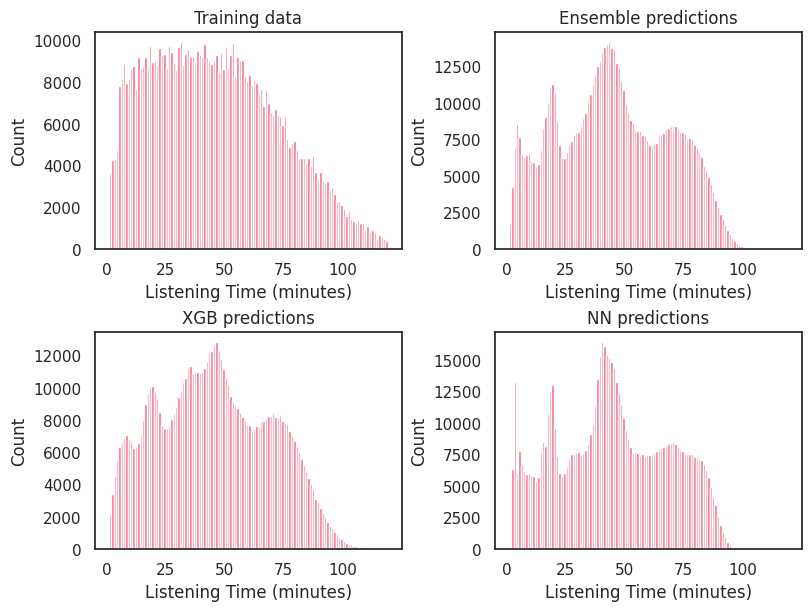

In [33]:
# Visulaize the distribution of the predictions
fig, axes = plt.subplots(2,2, figsize=(8, 6), constrained_layout=True)

axes[0, 0].hist(df_train["Listening_Time_minutes"], bins=range(1, 120))
axes[0, 0].set_title("Training data")
axes[0, 0].set_xlabel("Listening Time (minutes)")
axes[0, 0].set_ylabel("Count")

axes[0, 1].hist(y_pred_ens.numpy(), bins=range(1, 120))
axes[0, 1].set_title("Ensemble predictions")
axes[0, 1].set_xlabel("Listening Time (minutes)")
axes[0, 1].set_ylabel("Count")

axes[1, 0].hist(y_pred_xgb.numpy(), bins=range(1, 120))
axes[1, 0].set_title("XGB predictions")
axes[1, 0].set_xlabel("Listening Time (minutes)")
axes[1, 0].set_ylabel("Count")

axes[1, 1].hist(y_pred_NN.numpy(), bins=range(1, 120))
axes[1, 1].set_title("NN predictions")
axes[1, 1].set_xlabel("Listening Time (minutes)")
axes[1, 1].set_ylabel("Count")

plt.show()